In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib, os, random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Importing Data

In [3]:
train_set = "../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
valid_set = "../input/augmented-alzheimer-mri-dataset/OriginalDataset"

no_alzheimer_classes = os.listdir(train_set)
len(no_alzheimer_classes)

4

In [4]:
## Classes Name

data_dir = pathlib.Path(train_set)
alzheimer_classes = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(alzheimer_classes)

['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']


## Visualizing Images

In [5]:
def view_random_image(target_dir, target_class):
  
  # setting up the image directory
  target_folder = target_dir + '/' + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = plt.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  #print(f"Image shape: {img.shape}")
  
  return img

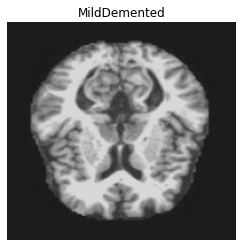

In [6]:
img = view_random_image(train_set,'MildDemented')

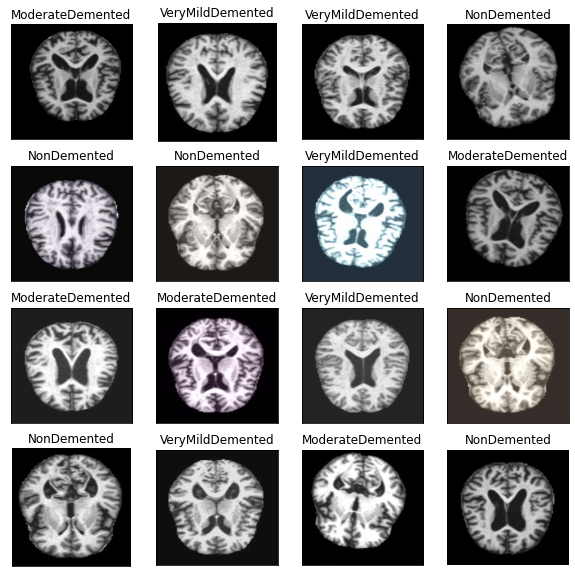

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0 , len(no_alzheimer_classes)-1 , 16)

for i, ax in enumerate(axes.flat):
    ax.imshow(view_random_image(train_set,no_alzheimer_classes[random_index[i]]))
    ax.set_title(no_alzheimer_classes[random_index[i]])

## Data Preprocessing  

In [8]:
## Data Augmentation

SIZE_X = SIZE_Y =224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split =0.2,rescale=1./255)
train_set = datagen.flow_from_directory(train_set, class_mode = 'categorical',
                                        target_size = (SIZE_X , SIZE_Y),
                                        color_mode = 'rgb',
                                        batch_size = 32,
                                        subset ='training')

validation_set = datagen.flow_from_directory(valid_set, class_mode = 'categorical',
                                        target_size = (224, 224),
                                        color_mode = 'rgb',
                                        batch_size = 32,
                                        subset ='validation')

Found 27188 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Model Building 

## 1. Custom Model

In [9]:
# Intialize the CNN
model_c = Sequential()

# 1st Convolution Block
model_c.add(Conv2D(filters = 16, kernel_size=(3, 3), input_shape = (224,224, 3), activation = 'relu'))  #1st Conv Layer
model_c.add(Conv2D(filters = 32, kernel_size=(3, 3), activation = 'relu'))        # 2nd Conv Layer

# Pooling Layer
model_c.add(MaxPool2D(pool_size=(2, 2)))


# 2nd Convolution Block
model_c.add(Conv2D(filters = 32, kernel_size=(3, 3), activation = 'relu'))  #3rd Conv Layer
model_c.add(Conv2D(filters = 32, kernel_size=(3, 3), activation = 'relu'))  #4th Conv Layer


# Pooling Layer
model_c.add(MaxPool2D(pool_size=(2, 2)))


# Flattening Layer
model_c.add(Flatten())


# Fully Connected Layer
model_c.add(Dense(128, activation = 'relu'))   # Hidden Layer 1
model_c.add(Dropout(0.5))
model_c.add(Dense(64, activation = 'relu'))   # Hidden Layer 2
model_c.add(Dropout(0.2))

model_c.add(Dense(4, activation = 'softmax'))  # Output Layer

2022-11-06 15:58:42.427632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 15:58:42.555422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 15:58:42.556185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 15:58:42.557401: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
model_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 89888)             0

In [11]:
# Compiling the Model
model_c.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
# Train the Model
history_c = model_c.fit(train_set, epochs = 10, validation_data = validation_set)

2022-11-06 15:59:44.077402: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-06 15:59:45.768570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


850/850 [==============================] - 193s 218ms/step - loss: 1.0377 - accuracy: 0.5010 - val_loss: 0.8073 - val_accuracy: 0.6161
Epoch 2/10
850/850 [==============================] - 63s 74ms/step - loss: 0.6656 - accuracy: 0.7015 - val_loss: 0.4494 - val_accuracy: 0.8288
Epoch 3/10
850/850 [==============================] - 65s 77ms/step - loss: 0.4942 - accuracy: 0.7841 - val_loss: 0.1731 - val_accuracy: 0.9320
Epoch 4/10
850/850 [==============================] - 67s 79ms/step - loss: 0.3988 - accuracy: 0.8274 - val_loss: 0.1094 - val_accuracy: 0.9664
Epoch 5/10
850/850 [==============================] - 66s 78ms/step - loss: 0.3375 - accuracy: 0.8557 - val_loss: 0.0686 - val_accuracy: 0.9812
Epoch 6/10
850/850 [==============================] - 65s 76ms/step - loss: 0.2935 - accuracy: 0.8744 - val_loss: 0.0541 - val_accuracy: 0.9781
Epoch 7/10
850/850 [==============================] - 64s 76ms/step - loss: 0.2571 - accuracy: 0.8918 - val_loss: 0.0510 - val_accuracy: 0.9820
E

## Evaluating the model 

In [13]:
result_c = model_c.evaluate(validation_set,batch_size=64)
print("Test Accuracy ------>",result_c[1]*100)
print("Test Loss ------>",result_c[0])

40/40 [==============================] - 3s 63ms/step - loss: 0.0610 - accuracy: 0.9797
Test Accuracy ------> 97.96715974807739
Test Loss ------> 0.06100213900208473


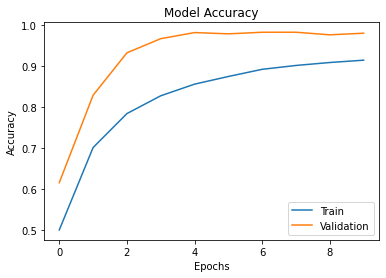

In [14]:
# Accuracy
plt.plot(history_c.history['accuracy'])
plt.plot(history_c.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

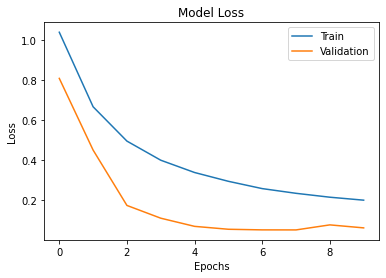

In [15]:
# Loss
plt.plot(history_c.history['loss'])
plt.plot(history_c.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

- We can observe that our custom model is fitted well on the particular dataset and giving the accuracy over 98%.

## 2. VGG16

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16

In [17]:
Image_Size = [224, 224]

# Create VGG16 Network
vgg = VGG16(input_shape = Image_Size + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 2s 0us/step


In [18]:
# Don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [19]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
# Fully Connected layer

flatten = Flatten()(vgg.output)

dense = Dense(64, activation = 'relu')(flatten)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation = 'relu')(dense)
dense = Dropout(0.1)(dense)
prediction = Dense(4, activation = 'softmax')(dense)

In [21]:
# Build the Model

model_vgg = Model(inputs = vgg.input, outputs = prediction)

In [22]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
# Compile the Model

model_vgg.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [24]:
# Train the Model

history_vgg = model_vgg.fit_generator(train_set, validation_data=validation_set, epochs = 10)

Epoch 1/10
850/850 [==============================] - 76s 85ms/step - loss: 0.9884 - accuracy: 0.5305 - val_loss: 0.9053 - val_accuracy: 0.5872
Epoch 2/10
850/850 [==============================] - 69s 81ms/step - loss: 0.8680 - accuracy: 0.6093 - val_loss: 0.7277 - val_accuracy: 0.7138
Epoch 3/10
850/850 [==============================] - 70s 82ms/step - loss: 0.8110 - accuracy: 0.6467 - val_loss: 0.6229 - val_accuracy: 0.7209
Epoch 4/10
850/850 [==============================] - 69s 81ms/step - loss: 0.7639 - accuracy: 0.6710 - val_loss: 0.6423 - val_accuracy: 0.7435
Epoch 5/10
850/850 [==============================] - 79s 93ms/step - loss: 0.7068 - accuracy: 0.6971 - val_loss: 0.5381 - val_accuracy: 0.8124
Epoch 6/10
850/850 [==============================] - 71s 83ms/step - loss: 0.6621 - accuracy: 0.7102 - val_loss: 0.5367 - val_accuracy: 0.8061
Epoch 7/10
850/850 [==============================] - 68s 80ms/step - loss: 0.6489 - accuracy: 0.7097 - val_loss: 0.4874 - val_accuracy:

In [25]:
result_vgg = model_vgg.evaluate(validation_set,batch_size=64)
print("Test Accuracy ------>",result_vgg[1]*100)
print("Test Loss ------>",result_vgg[0])

40/40 [==============================] - 3s 68ms/step - loss: 1.1848 - accuracy: 0.3495
Test Accuracy ------> 34.949180483818054
Test Loss ------> 1.1847705841064453


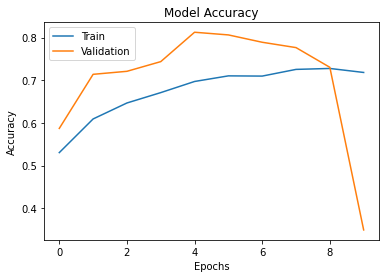

In [26]:
# Accuracy
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

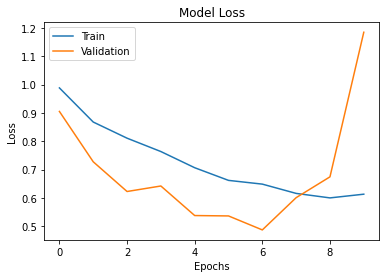

In [27]:
# Loss
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

- We can clearly observe that VGG16 perform terrible on the dataset with the overall accuracy of 35%.

## Comparision

<AxesSubplot:xlabel='Models', ylabel='Accuracy'>

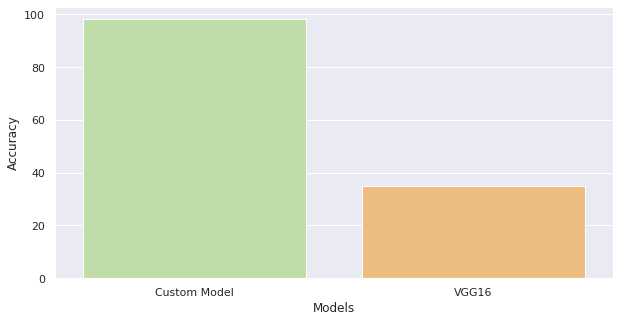

In [28]:
Models = pd.DataFrame({'Models':['Custom Model', 'VGG16'], 'Accuracy': [result_c[1]*100,result_vgg[1]*100]})
                                                                        
plt.figure(figsize=(10,5))
sns.set()
sns.barplot(Models['Models'], Models['Accuracy'],palette="Spectral_r")

## Predicting Test Set - Using Custom Model

In [29]:
pred = model_c.predict(validation_set)
pred = np.argmax(pred,axis=1)

True Label: ModerateDemented
Predicted Label: ModerateDemented


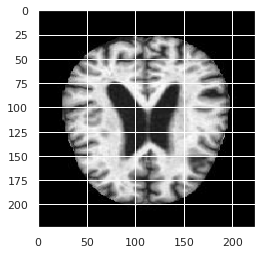

In [30]:
index =10

img , label = validation_set[index]
label = validation_set.labels[index]
print(f"True Label: {no_alzheimer_classes[label]}")
print(f"Predicted Label: {no_alzheimer_classes[pred[index]]}")  
plt.imshow(img[0])
plt.show()

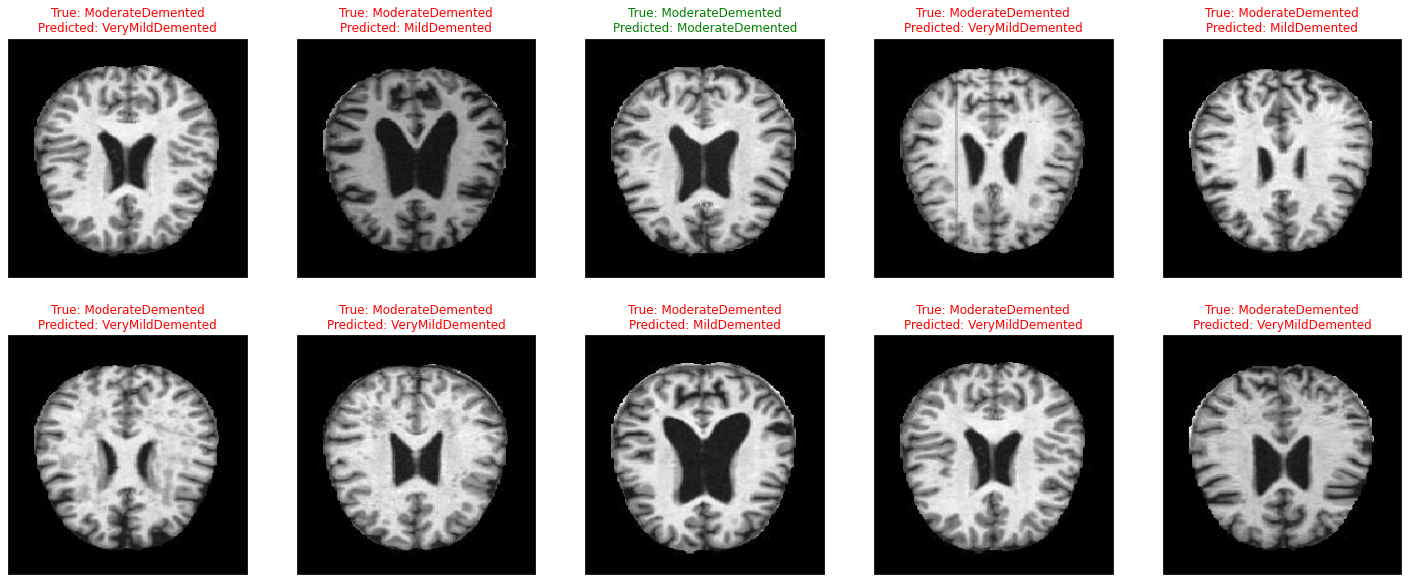

<Figure size 432x288 with 0 Axes>

In [31]:
# Display 10 random pictures from the dataset with their labels

random_index = np.random.randint(0, len(validation_set) - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    randImg , randLabel = validation_set[random_index[i]]
    randLabel = validation_set.labels[random_index[i]]
    ax.imshow(randImg[0])
    if no_alzheimer_classes[randLabel] == no_alzheimer_classes[pred[random_index[i]]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {no_alzheimer_classes[randLabel]}\nPredicted: {no_alzheimer_classes[pred[random_index[i]]]}", color=color)
plt.show()
plt.tight_layout()

In [32]:
model_c.save("Alzheimer_Classification.h5")